# Post-Processing Statistical Models in Chapter 6

This notebook processes the brms/stan output and creates the figures used in this chapter.

In [ ]:
rm(list = ls())
library(brms)
library(tidyverse)
library(ggplot2)
library(modelr)
library(tidybayes)
library(dplyr)
library(cowplot)
## Some helper functions, and configurations.
source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/configurations.r")
source("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/configurations/user_functions.r")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/clean_data/pooled.auth.rda")  ### Just work from this data; everything should be here, recoded.
## models
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapter8/Chapter6/vote_model.rda")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapter8/Chapter6/party_model.rda")
load("/Users/chrisweber/Desktop/Authoritarianism_V2/Authoritarianism_V2/Chapters/Chapter8/Chapter6/affect.rda")


ggtheme = theme(
        plot.title=element_text(face="bold",hjust=-.08,vjust=0,colour="#3C3C3C",size=12),
        axis.text.x=element_text(size=9,colour="#535353",face="bold"),
        axis.text.y=element_text(size=9,colour="#535353",face="bold"),
        axis.title.y=element_text(size=11,colour="#535353",face="bold",vjust=1.5),
        axis.ticks=element_blank(),
        panel.grid.major=element_line(colour="#D0D0D0",size=.25),
        panel.background=element_rect(fill="white")) 
####

First, let's look at the fit and graphically compare the linear and quadratic specifications. I call it "expanded_dat" because it's effectively creating a (very) long database structure, as opposed to more typical "wide" tabular dataframe.

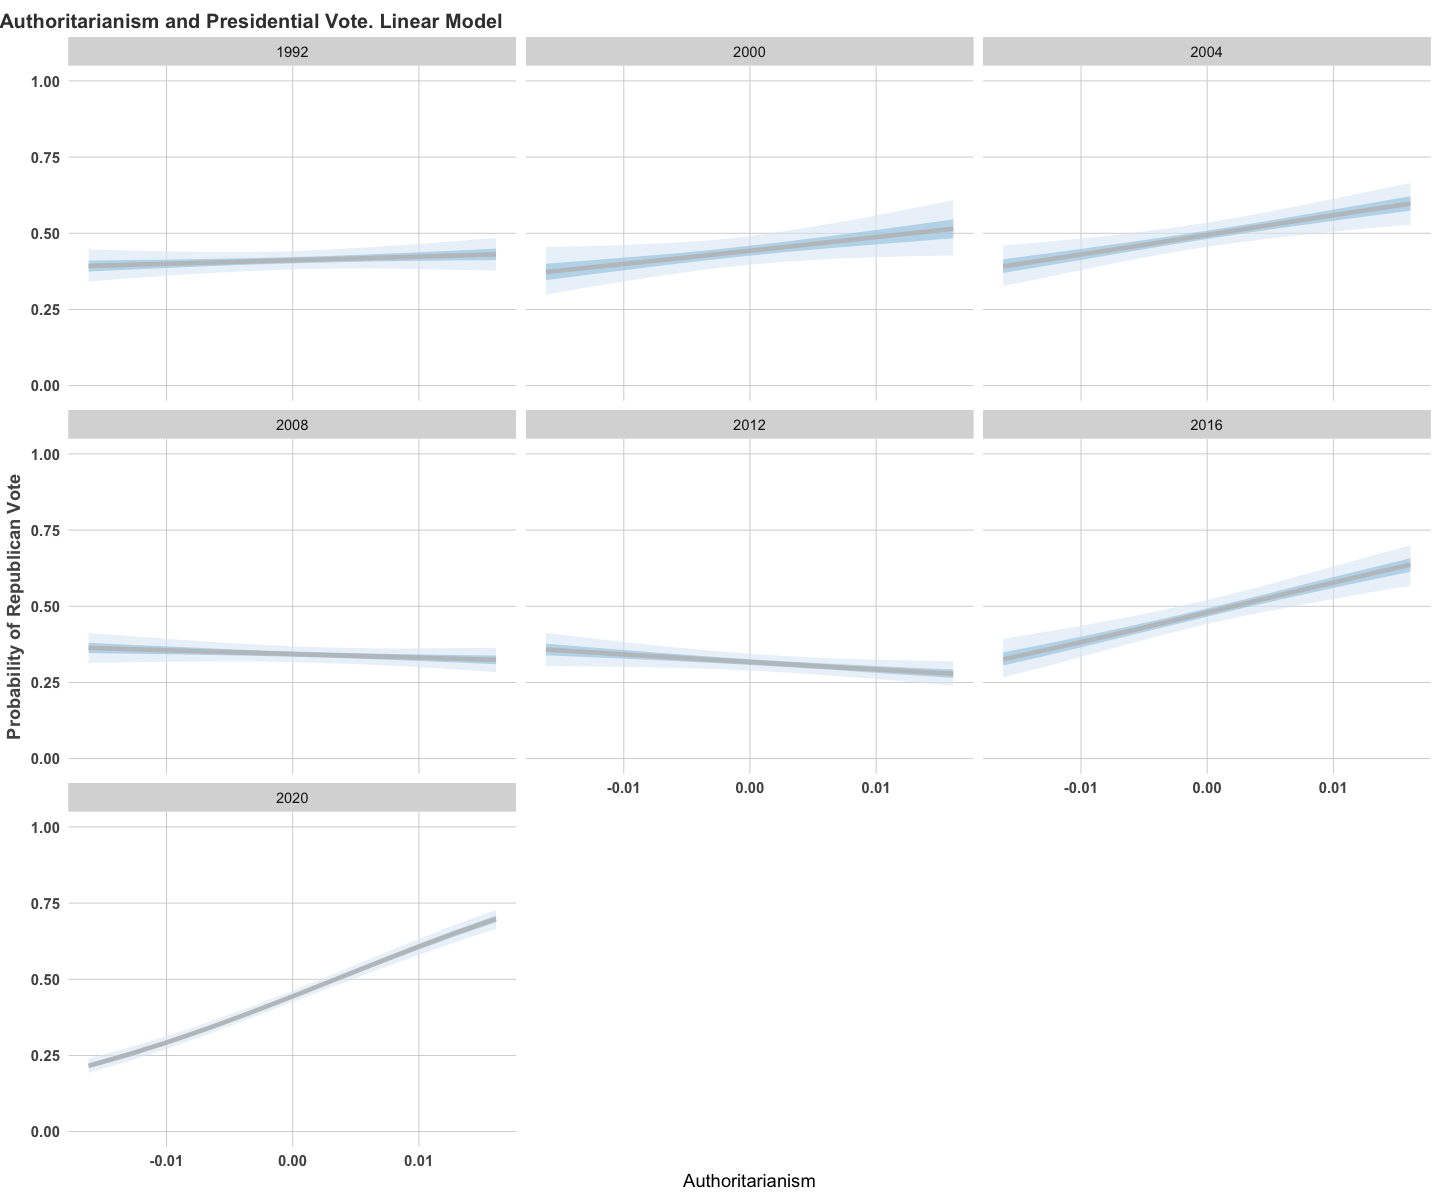

In [71]:
## Pull out the relevant models from my output.
fit0b = vote_models[[2]]
fit1  = vote_models[[3]]

## Expand the data used to estimate this model
model0 = data[,c("vote", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(auth = poly(authoritarianism, 2)) %>% 
                 mutate(authoritarianism = auth[,1]) %>%
                 group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), authoritarianism = seq_range(authoritarianism, n = 11))  %>% 
                                                      mutate(authoritarianism_2 = authoritarianism^2) %>%  
                                                      add_linpred_draws(fit0b) %>% 
                                                      mutate(Vote_Republican = plogis(.linpred))  
options(repr.plot.width=12, repr.plot.height=10)

## Plot linear Effects
 model0 %>%  ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, .5), color = "grey", alpha = 0.6) +
            scale_fill_brewer()  +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Linear Model") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none")
  

In [98]:
test = c(1,3,3,3,2,1)

poly(test,2)


1,2
-0.5306686,0.2274294
0.3790490,0.1516196
0.3790490,0.1516196
0.3790490,0.1516196
-0.0758098,-0.9097177
-0.5306686,0.2274294


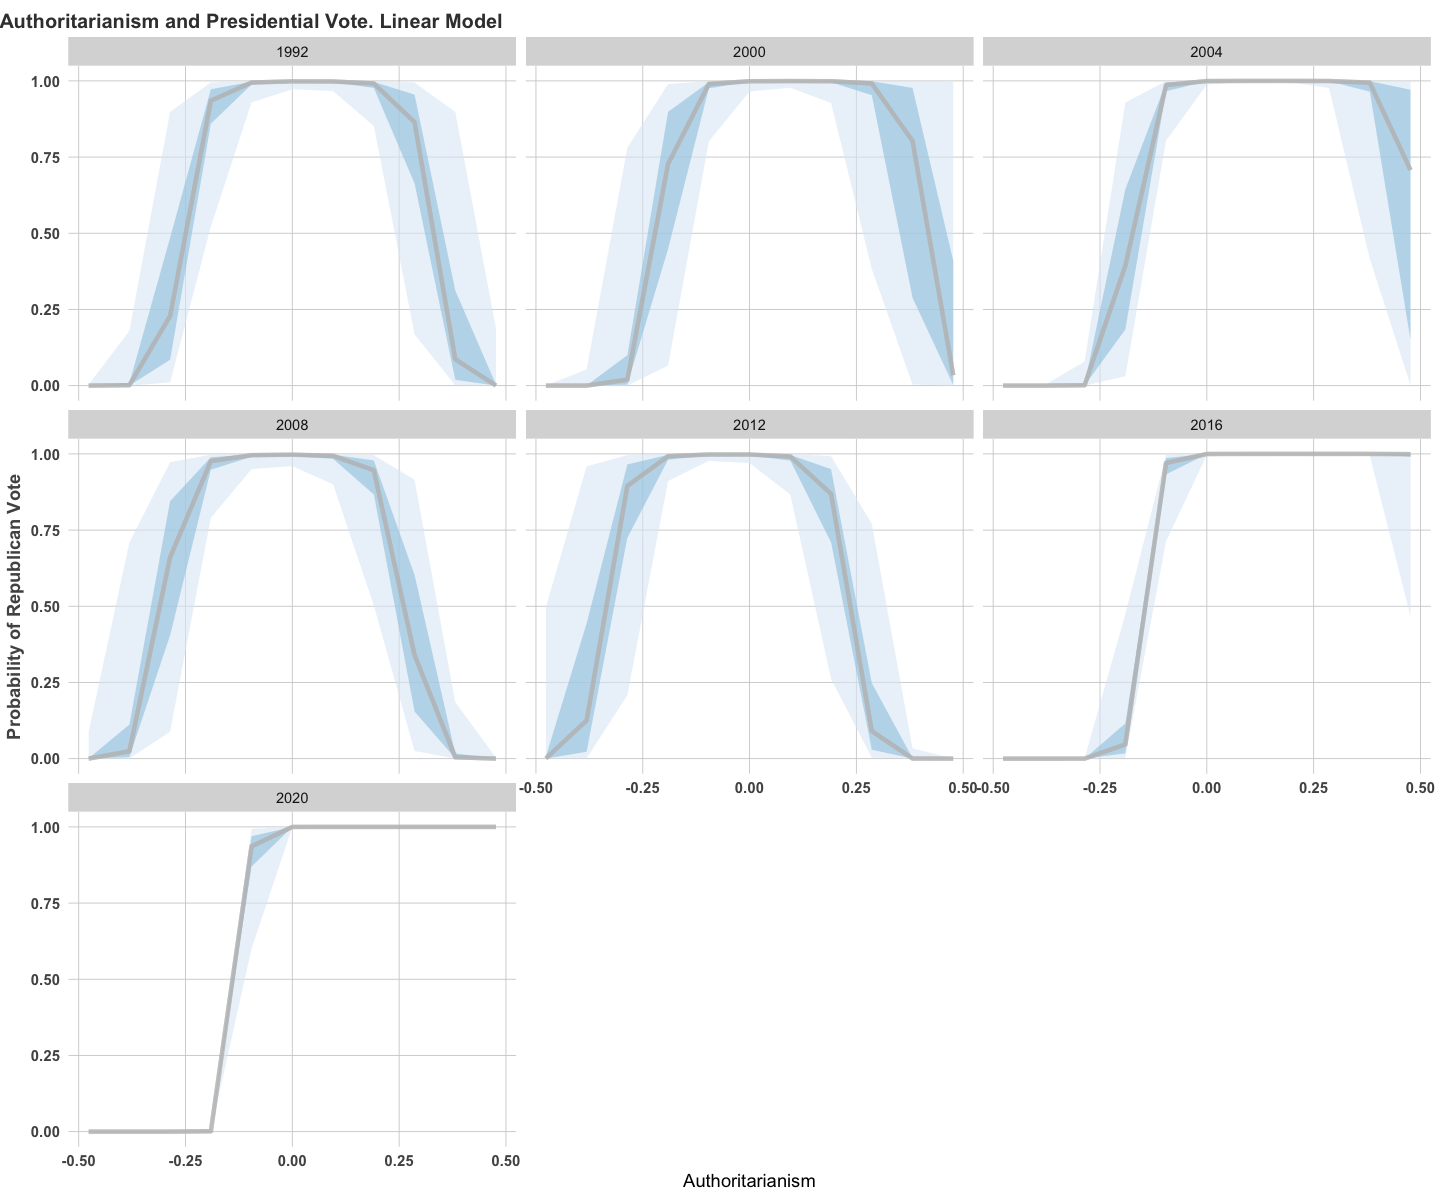

In [101]:
 # Quadratic Model (Fit1)
model1 = data[,c("vote", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
#                 mutate(auth = poly(authoritarianism, 2)) %>% 
#                 mutate(authoritarianism = auth[,1]) %>%
                 group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), auth = seq_range(authoritarianism, n = 11))  %>% 
                                                      mutate(authoritarianism = poly(auth, 2)[,1]) %>% 
                                                      mutate(authoritarianism_2 = poly(auth, 2)[,2]) %>%  
                                                      add_linpred_draws(fit1) %>% 
                                                      mutate(Vote_Republican = plogis(.linpred))    

 model1 %>%  ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, .5), color = "grey", alpha = 0.6) +
            scale_fill_brewer()  +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Linear Model") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none")
  

In [84]:
med

year,female,age,college,income,catholic,jewish,other,authoritarianism,tmp,authoritarianism_2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<poly[,2]>",<dbl>
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,-4.767313e-01,"-4.767313e-01, 0.51209156",0.51209156
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,-3.813850e-01,"-3.813850e-01, 0.20483662",0.20483662
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,-2.860388e-01,"-2.860388e-01, -0.03413944",-0.03413944
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,-1.906925e-01,"-1.906925e-01, -0.20483662",-0.20483662
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,-9.534626e-02,"-9.534626e-02, -0.30725493",-0.30725493
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,-2.561299e-17,"-2.561299e-17, -0.34139437",-0.34139437
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,9.534626e-02,"9.534626e-02, -0.30725493",-0.30725493
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,1.906925e-01,"1.906925e-01, -0.20483662",-0.20483662
1992,0.5506329,0.3979299,0.2890295,0.3628692,0.2478903,0.02531646,0.1191983,2.860388e-01,"2.860388e-01, -0.03413944",-0.03413944


# Predicted Values, Voting (1992 - 2020)

These models can be passed to $\texttt{tidybayes}$ to produce figures. 

The $\texttt{expanded\_dat}$ call just creates an expanded version of the data. The full posterior prediction is saved, varying authoritarianism, holding everything else at means. 

# Cross Validation

All three models fit the data well. The fit-statistics/examining the traceplots all show convergence. One useful statistic to ascertain what model fits better is leave-one-out cross validation. It's the same as K-fold cross-validation, but instead, we estimate the model on everything except one data point and then we predict that data point. Leave-one-out cross validation supports the quadratic, random slopes/intercepts model.


In [27]:
# Generate an expanded dataset varying levels of authoritarianism at fixed covariates.
### linear model (fit0b) ###
fit0a = vote_models[[1]]
fit0b = vote_models[[2]]
fit1  = vote_models[[3]]

loo(fit0a, fit0b, fit1)

Output of model 'fit0a':

Computed from 4500 by 8327 log-likelihood matrix

         Estimate   SE
elpd_loo  -5375.0 27.5
p_loo        14.8  0.2
looic     10750.0 55.0
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Output of model 'fit0b':

Computed from 4500 by 8327 log-likelihood matrix

         Estimate   SE
elpd_loo  -5269.1 30.2
p_loo        20.2  0.2
looic     10538.1 60.4
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Output of model 'fit1':

Computed from 4500 by 8327 log-likelihood matrix

         Estimate   SE
elpd_loo  -5207.4 31.6
p_loo        23.6  0.3
looic     10414.7 63.3
------
Monte Carlo SE of elpd_loo is 0.1.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

Model comparisons:
      elpd_diff se_diff
fit1     0.0       0.0 
fit0b  -61.7      11.2 
fit0a -167

In [31]:
names(data)

[1] "abortion"             "age"                  "aid.blacks"          
  [4] "aid.blacksCD"         "aid.blacksCR"         "aid.blacksD"         
  [7] "aid.blacksR"          "anger.dem"            "anger.rep"           
 [10] "auth.1"               "auth.2"               "auth.3"              
 [13] "auth.4"               "bible"                "black"               
 [16] "catholic"             "church"               "college"             
 [19] "defense.spendingCD"   "defense.spendingCR"   "defense.spendingD"   
 [22] "defense.spendingR"    "dem.afraid"           "dem.angry"           
 [25] "dem.cares"            "dem.decent"           "dem.hope"            
 [28] "dem.know"             "dem.leader"           "efficacy1"           
 [31] "efficacy2"            "efficacy3"            "efficacy4"           
 [34] "efficacy5"            "efficacy6"            "efficacy7"           
 [37] "egal1"                "egal2"                "egal3"               
 [40] "egal4"                "fear.dem"             "fear.rep"            
 [43] "feel.asian"           "feel.black"           "feel.latino"         
 [46] "feeling.dem"          "feeling.demc"         "feeling.rep"         
 [49] "feeling.repc"         "female"               "feminists.therm"     
 [52] "fundamental.therm"    "gay.therm"            "gays.adoption"       
 [55] "gays.military"        "gov.services"         "gov.servicesCD"      
 [58] "gov.servicesCR"       "gov.servicesD"        "gov.servicesR"       
 [61] "hispanic"             "hope.dem"             "hope.rep"            
 [64] "ideology"             "ideologyCD"           "ideologyCR"          
 [67] "ideologyD"            "ideologyR"            "immigrants"          
 [70] "income"               "interest.elections"   "interest.politics"   
 [73] "jewish"               "jobs"                 "jobsCD"              
 [76] "jobsCR"               "jobsD"                "jobsR"               
 [79] "know.interview.post"  "know.interview.pre"   "media"               
 [82] "mode"                 "moral1"               "moral2"              
 [85] "moral3"               "moral4"               "nonwhite"            
 [88] "other"                "other.race"           "p1"                  
 [91] "p2"                   "p3"                   "p4"                  
 [94] "p5"                   "pid"                  "primary"             
 [97] "protect.gays"         "proud.dem"            "proud.rep"           
[100] "public.insurance"     "public.insuranceCD"   "public.insuranceCR"  
[103] "rep.afraid"           "rep.angry"            "rep.cares"           
[106] "rep.decent"           "rep.hope"             "rep.know"            
[109] "rep.leader"           "rid"                  "rr1"                 
[112] "rr2"                  "rr3"                  "rr4"                 
[115] "split.house"          "split.senate"         "union.therm"         
[118] "vote"                 "vote.house"           "vote.senate"         
[121] "voted"                "weights.all"          "weights.ftf"         
[124] "weights.web"          "white"                "women.role"          
[127] "women.roleCD"         "women.roleCR"         "year"                
[130] "rid2"                 "group"                "racial.resentment"   
[133] "authoritarianism"     "identifier"           "efficacy"            
[136] "knowledge"            "republican"           "dem_traits"          
[139] "participation"        "AuthXRep"             "egalitarianism"      
[142] "moral.traditionalism" "services"

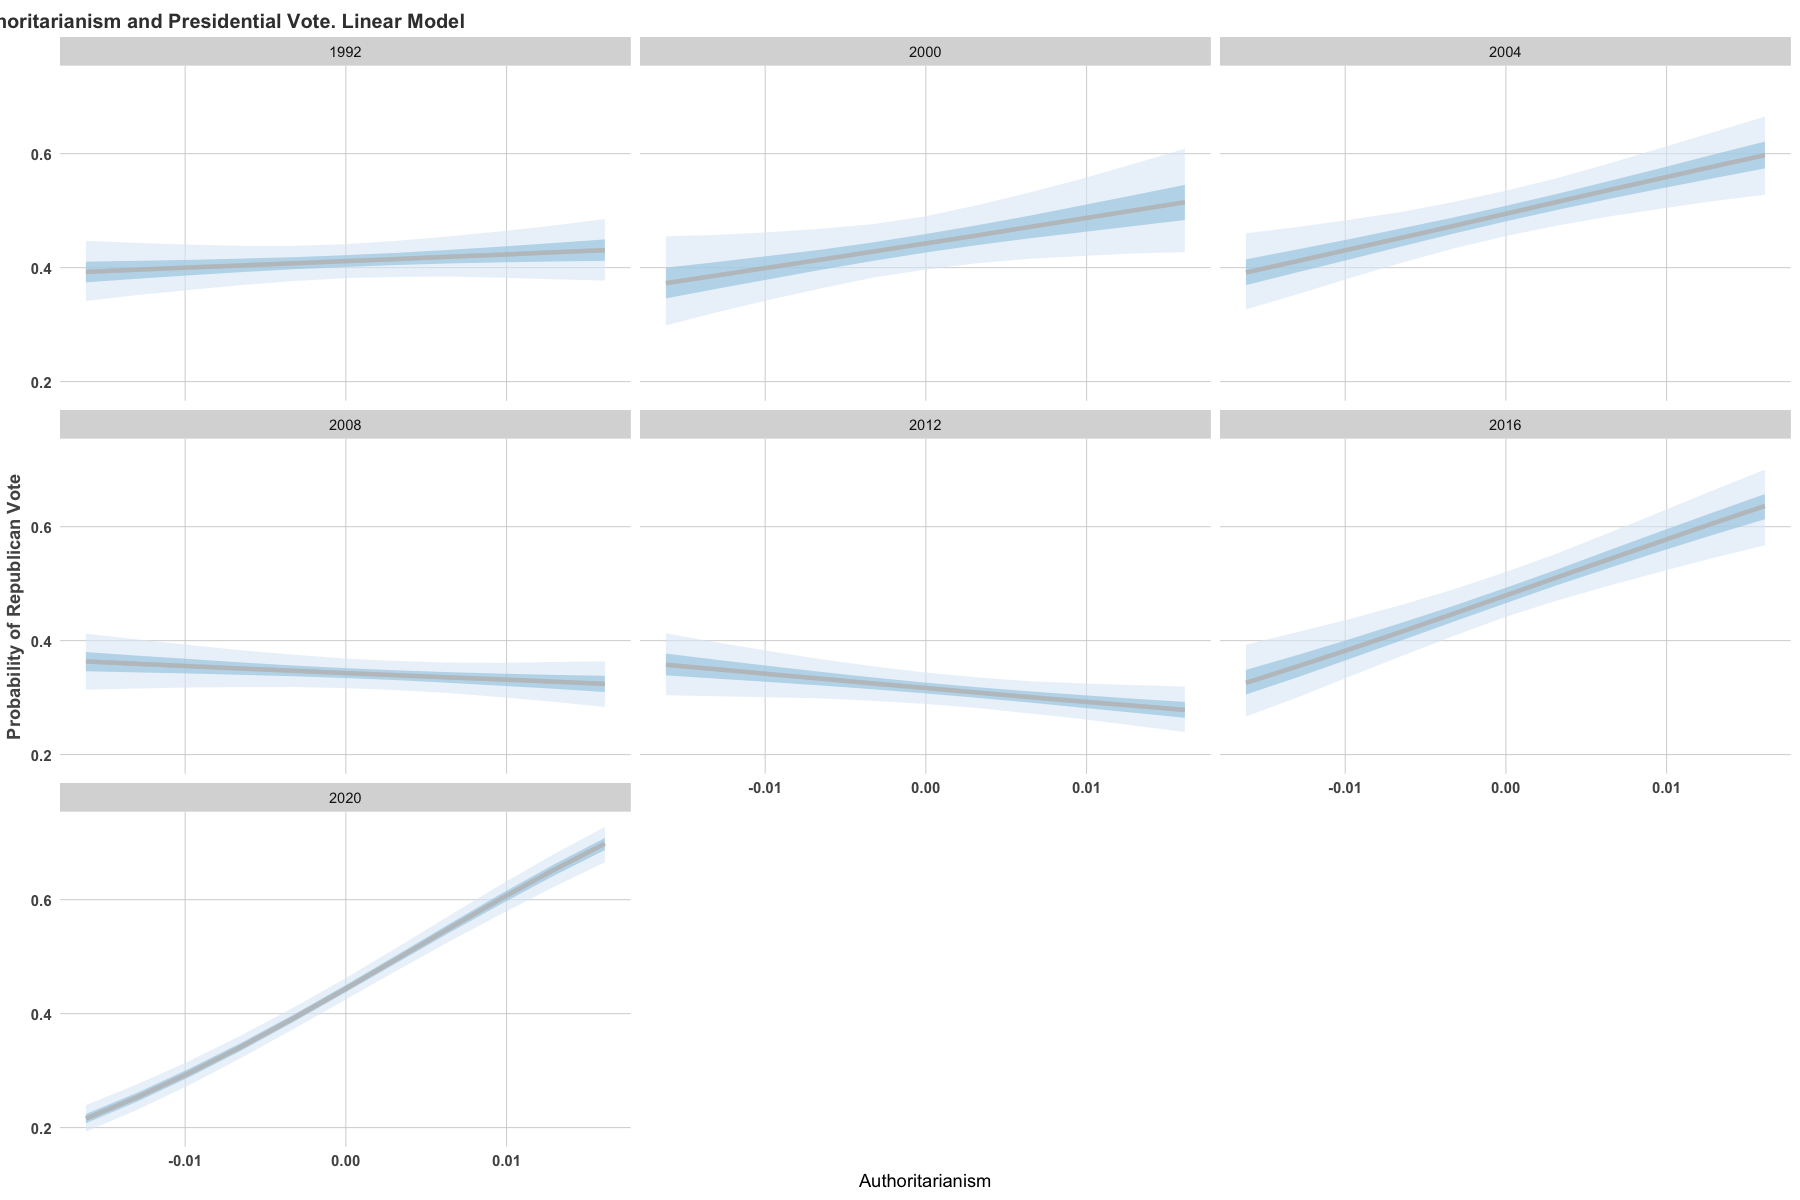

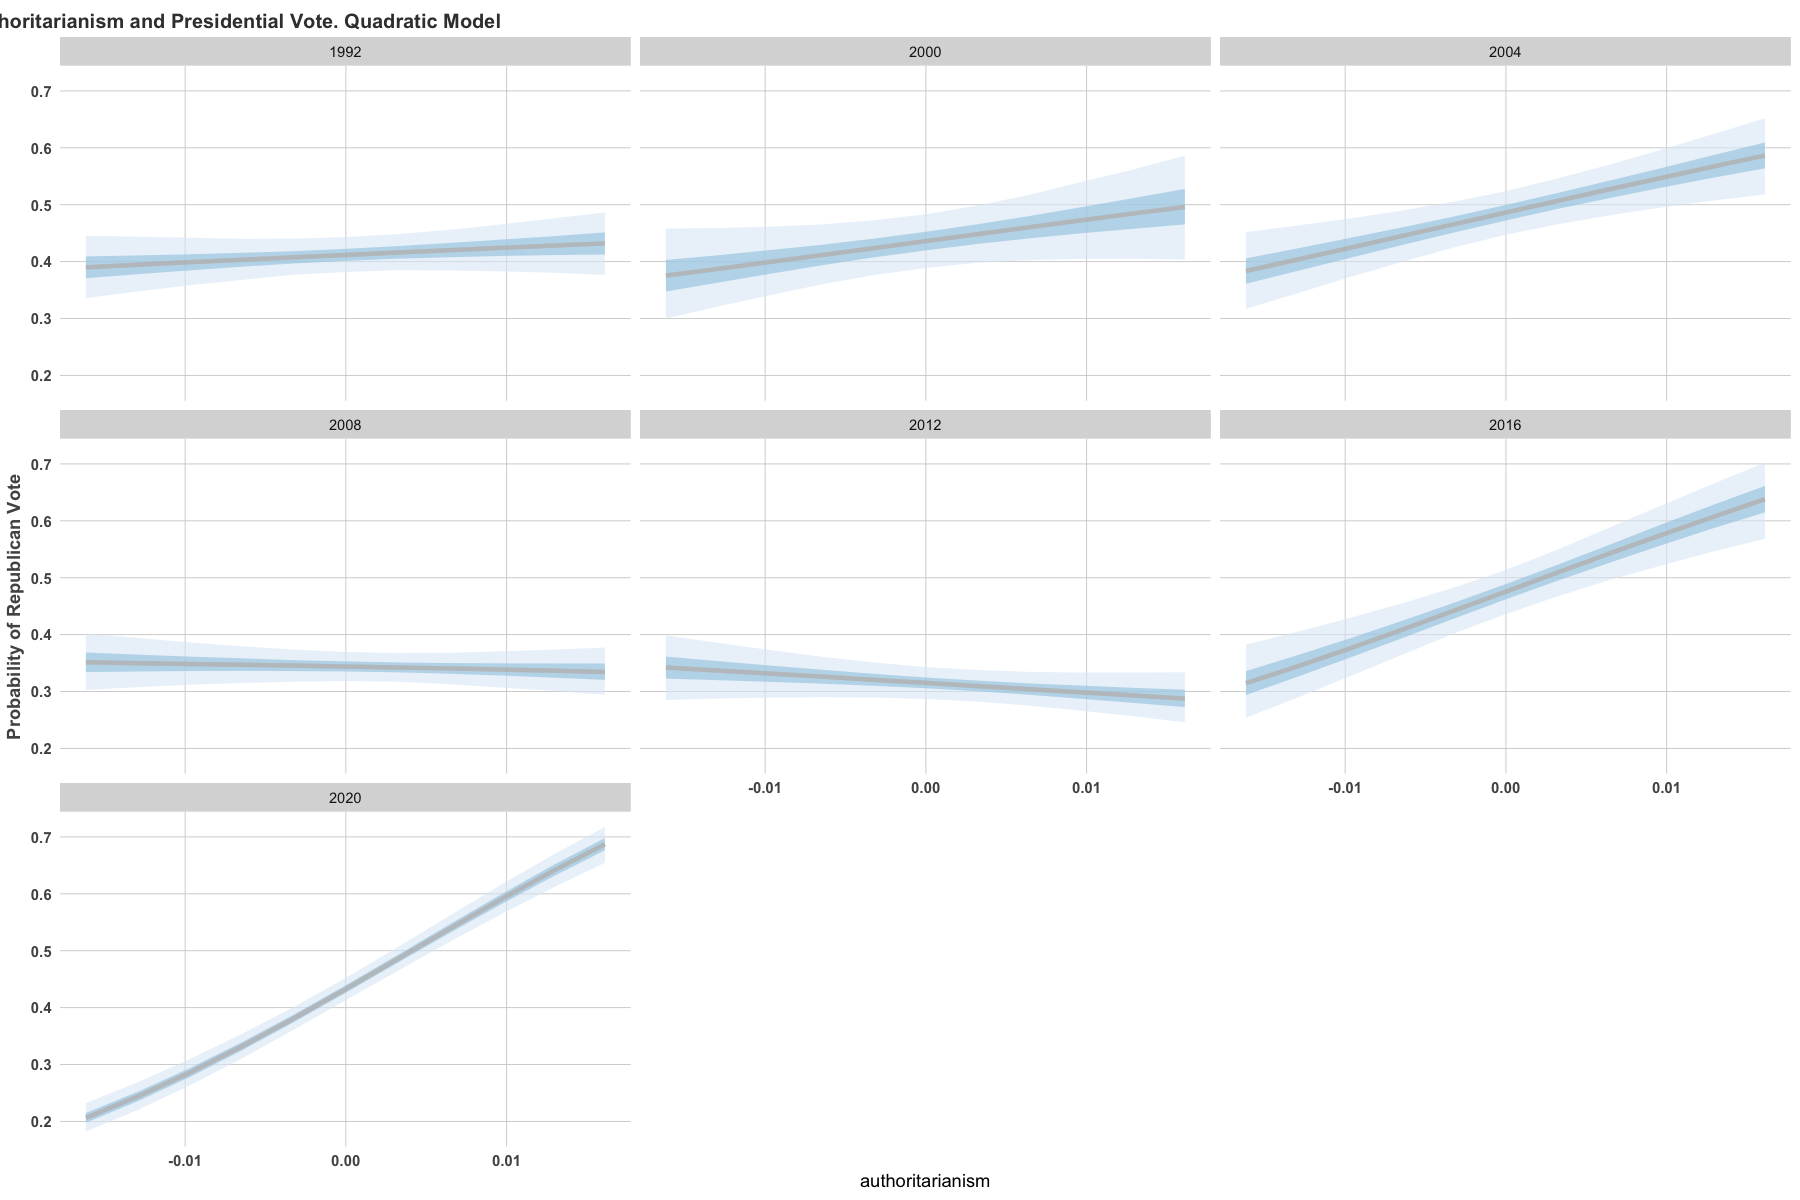

In [51]:

tmp_dat = data[,c("vote", "authoritarianism", 
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>% 
                 mutate(auth = poly(authoritarianism, 2)) %>% 
                 mutate(authoritarianism = auth[,1]) %>%
                 mutate(authoritarianism_2 = auth[,2]) 
                 
model0 = tmp_dat %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%  
                                                      # Fit the data with fit0b
                                                      add_linpred_draws(fit0b) %>%
                                                      mutate(Vote_Republican = plogis(.linpred))  %>% 
                                                      mutate(x_axis = zero.one(authoritarianism)) 

model1 = tmp_dat %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age), 
                                                      college = mean(college), income = mean(income), 
                                                      catholic =  mean(catholic), jewish = mean(jewish), 
                                                      other = mean(other), 
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%   
                                                      mutate(authoritarianism_2 = authoritarianism^2) %>%  
                                                      # Fit the model with fit1
                                                      add_linpred_draws(fit1) %>% 
                                                      mutate(Vote_Republican = plogis(.linpred))  %>%
                                                      mutate(x_axis = zero.one(authoritarianism)) 

          
options(repr.plot.width=15, repr.plot.height=10)

 model0 %>%  ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, .5), color = "grey", alpha = 0.6) +
            scale_fill_brewer()  +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Linear Model") +
  scale_y_continuous("Probability of Republican Vote") + 
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none") 
  
  model1 %>%  ggplot(aes(x = authoritarianism)) + facet_wrap(~year) + 
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, .5), color = "grey", alpha = 0.6) +
            scale_fill_brewer()  +
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote. Quadratic Model") +
  scale_y_continuous("Probability of Republican Vote") + 
  ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none") 

  

In [47]:
head(tmp_dat)

,vote,authoritarianism,female,age,college,income,jewish,catholic,other,year,auth,authoritarianism_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,2]>",<dbl>
3,1,0.008041350,0,0.4000,0,1,0,0,0,2000,"0.008041350, -0.005028394",-0.005028394
4,0,-0.008102744,0,0.4125,1,0,0,0,1,2004,"-0.008102744, -0.006280570",-0.006280570
10,1,-0.008102744,1,0.3750,1,1,0,0,0,2004,"-0.008102744, -0.006280570",-0.006280570
11,0,0.016113396,0,0.4750,0,1,0,0,0,2008,"0.016113396, 0.015709688",0.015709688
12,1,-0.016174791,0,0.4000,1,0,0,1,0,2012,"-0.016174791, 0.013205336",0.013205336
16,0,0.016113396,0,0.5875,0,0,0,0,1,2004,"0.016113396, 0.015709688",0.015709688


In [43]:
head(tmp_dat)

,vote,authoritarianism,female,age,college,income,jewish,catholic,other,year,auth,authoritarianism_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,2]>",<dbl>
3,1,0.008041350,0,0.4000,0,1,0,0,0,2000,"0.008041350, -0.005028394",-0.005028394
4,0,-0.008102744,0,0.4125,1,0,0,0,1,2004,"-0.008102744, -0.006280570",-0.006280570
10,1,-0.008102744,1,0.3750,1,1,0,0,0,2004,"-0.008102744, -0.006280570",-0.006280570
11,0,0.016113396,0,0.4750,0,1,0,0,0,2008,"0.016113396, 0.015709688",0.015709688
12,1,-0.016174791,0,0.4000,1,0,0,1,0,2012,"-0.016174791, 0.013205336",0.013205336
16,0,0.016113396,0,0.5875,0,0,0,0,1,2004,"0.016113396, 0.015709688",0.015709688
